In [1]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import jax.numpy as jnp
import numpy.fft as fft
from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD
from ripple import ms_to_Mc_eta
import matplotlib.pyplot as plt

In [125]:
# define sampling rate and duration
fsamp = 8192
duration = 4

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]
print(delta_f)

0.25


In [167]:
# Now lets compute the waveform ripple
m1 = 50.0
m2 = 10.0
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
chi1 = 0.4
chi1_2 = 0.1
chi2 = -0.3
D = 2000.0
# tc = duration/1.0
tc = 2.
phic = 0.0

fmin = 30
f_list = freqs[freqs>fmin]
params_1 = jnp.array([Mc, eta, chi1_1, chi2, D, tc, phic])
params_2 = jnp.array([Mc, eta, chi1_2, chi2, D, tc, phic])

In [168]:
def pad_low_freqs(f, wvf_ref):
    f1 = 0.8*fmin
    return wvf_ref*(np.exp(((fmin-f1)/(f-f1) + (fmin-f1)/(f-fmin))) + 1)**(-1)

full_wvf_1 = np.zeros(len(freqs), dtype=np.complex128)
full_wvf_2 = np.zeros(len(freqs), dtype=np.complex128)
for i,f in enumerate(freqs):
    if f >= fmin:
        full_wvf_1[i] = gen_IMRPhenomD(f, params_1)
        full_wvf_2[i] = gen_IMRPhenomD(f, params_2)
    if f > 0.8*fmin and f < fmin:
        full_wvf_1[i] = pad_low_freqs(f, gen_IMRPhenomD(f, params_1))
        full_wvf_2[i] = pad_low_freqs(f, gen_IMRPhenomD(f, params_2))
    if f <= 0.8*fmin:
        full_wvf_1[i] = 0.0
        full_wvf_2[i] = 0.0

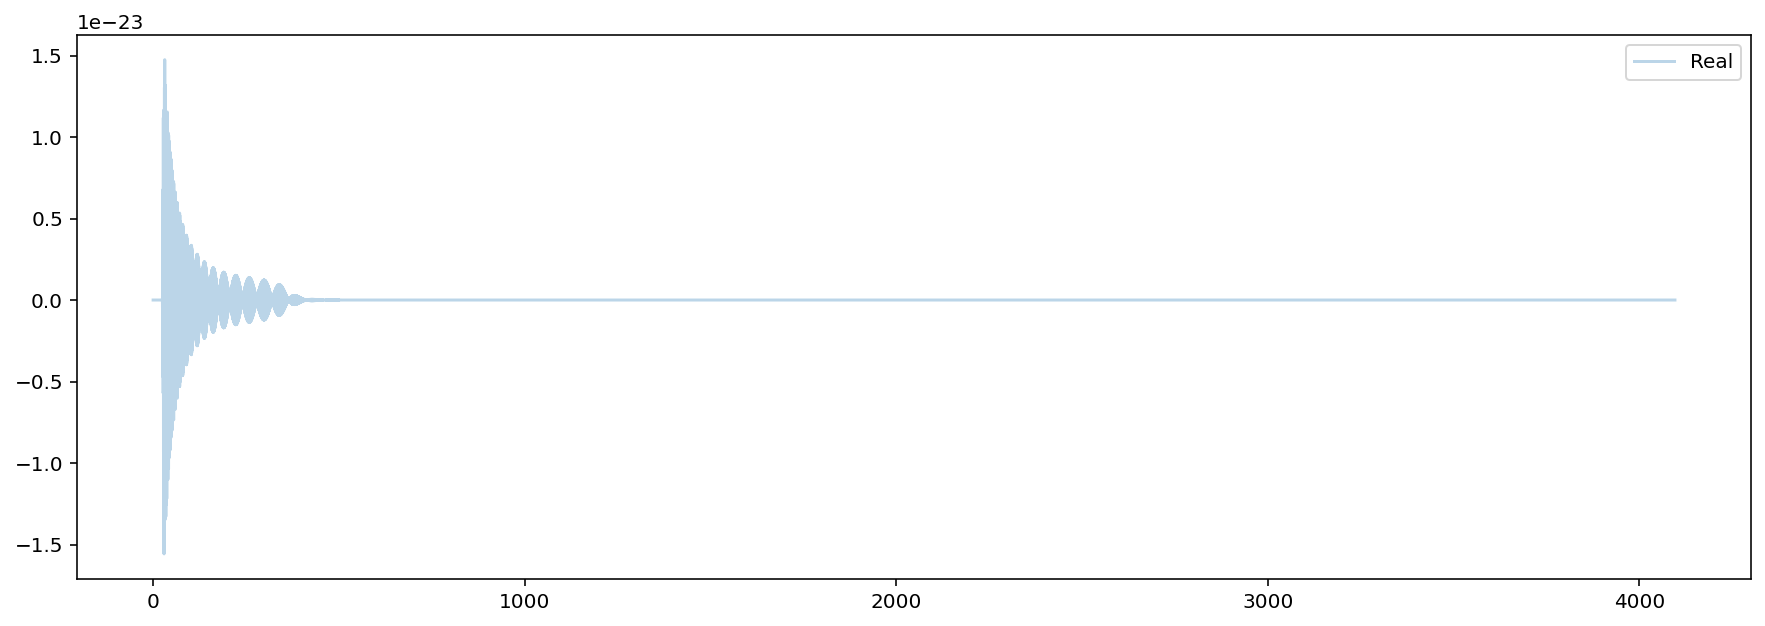

In [169]:
plt.figure(figsize=(15,5))
plt.plot(freqs, full_wvf_1.real, label="Real", alpha=0.3)
# plt.plot(freqs, full_wvf_1.imag, label="Imaginary", alpha=0.3)
# plt.plot(freqs, full_wvf_2, label="Signal 2")
plt.legend()
# plt.xlim(30,40)
plt.show()

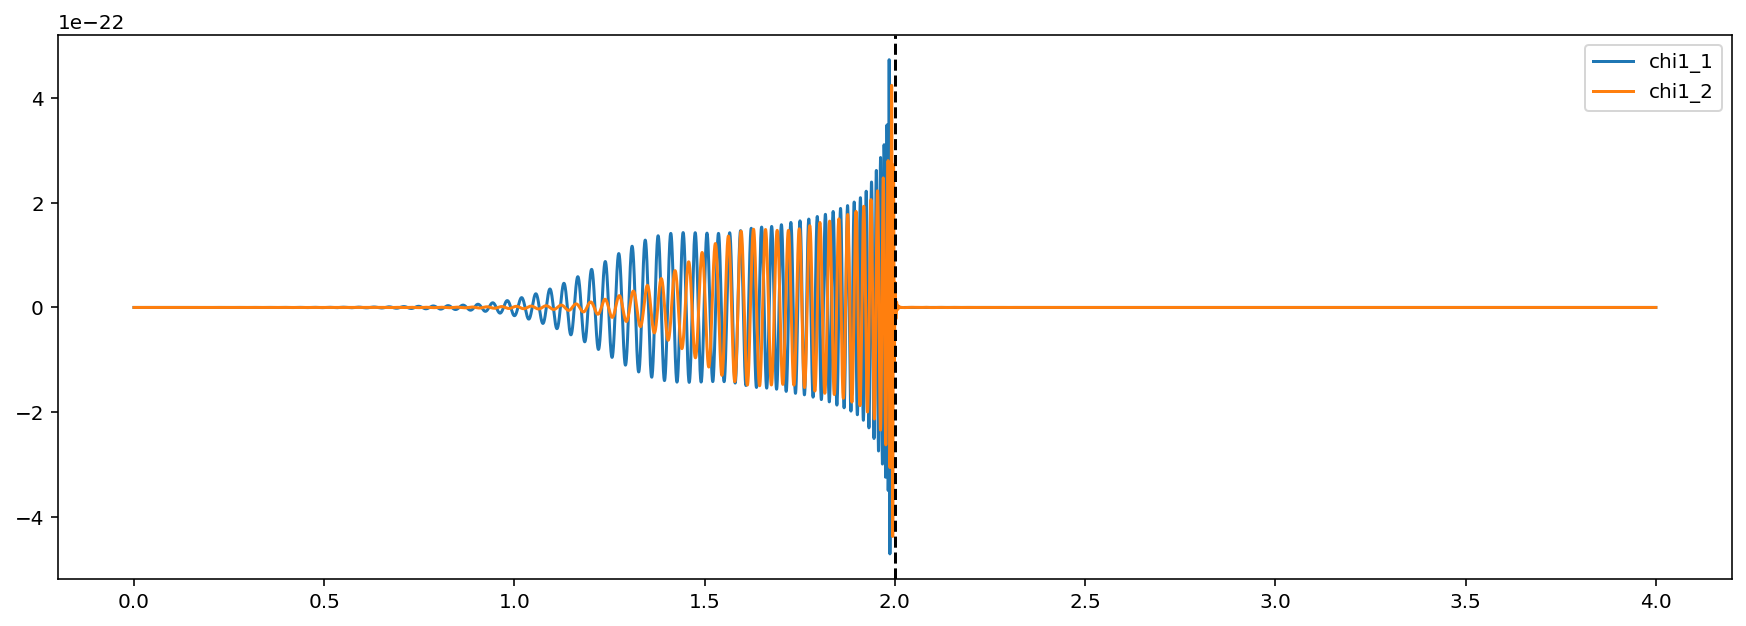

In [170]:
plt.figure(figsize=(15,5))
full_wvf_td_1 = fft.irfft(full_wvf_1) / delta_t
full_wvf_td_2 = fft.irfft(full_wvf_2) / delta_t

ts = np.arange(tlen)*delta_t
plt.plot(ts, full_wvf_td_1, label='chi1_1')
plt.plot(ts, full_wvf_td_2, label='chi1_2')

# if tc < 0.0:
#     plt.axvline(x=ts[-1]+tc, ls="--", color="C0")
#     plt.axvline(x=ts[-(1 + roll)]+tc, ls="--", color="C1")
# else:
#     plt.axvline(x=tc, ls="--", color="C0")
#     if tc-ts[roll] < 0.0:
#         tc_rolled = tc-ts[roll] + ts[-1]
#     else:
#         tc_rolled = tc-ts[roll]
#     plt.axvline(x=tc_rolled, ls="--", color="C1")

# plt.xlim(tc-0.1, tc+4.0)
plt.axvline(x=tc, ls="--", color="k")
# plt.axvline(x=tc-tcstar2, ls="--", color="C1")

plt.legend()
# plt.xlim(30,40)

In [162]:
from ripple import get_m1_m2_sampler
import jax
rng_key = jax.random.PRNGKey(0)

N = 100000
m12_sampler = get_m1_m2_sampler((1,40), (1,40))
m12_test = m12_sampler(rng_key, N)
chi1 = np.random.uniform(-1,1,N)
chi2 = np.random.uniform(-1,1,N)

chi_eff = (m12_test[:,0]*chi1 + m12_test[:,1]*chi2)/(m12_test[:,0]+m12_test[:,1])
print(chi_eff.min(), chi_eff.max())

-0.9963708652597854 0.9963301188355266
